In [1]:
node_shape: str = "ellipse"
filter_resources_related_to: str = ""
exclude_incoming_relationships: str = "false"

In [2]:
import graphviz
from code_data_science import data_table as dt
import html

df = dt.read_csv("../samples/call_graph.csv")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
df["dependent"] = df["fromClass"] + ' ' + df["fromName"]
df["dependency"] = df["toClass"] + ' ' + df["toName"]

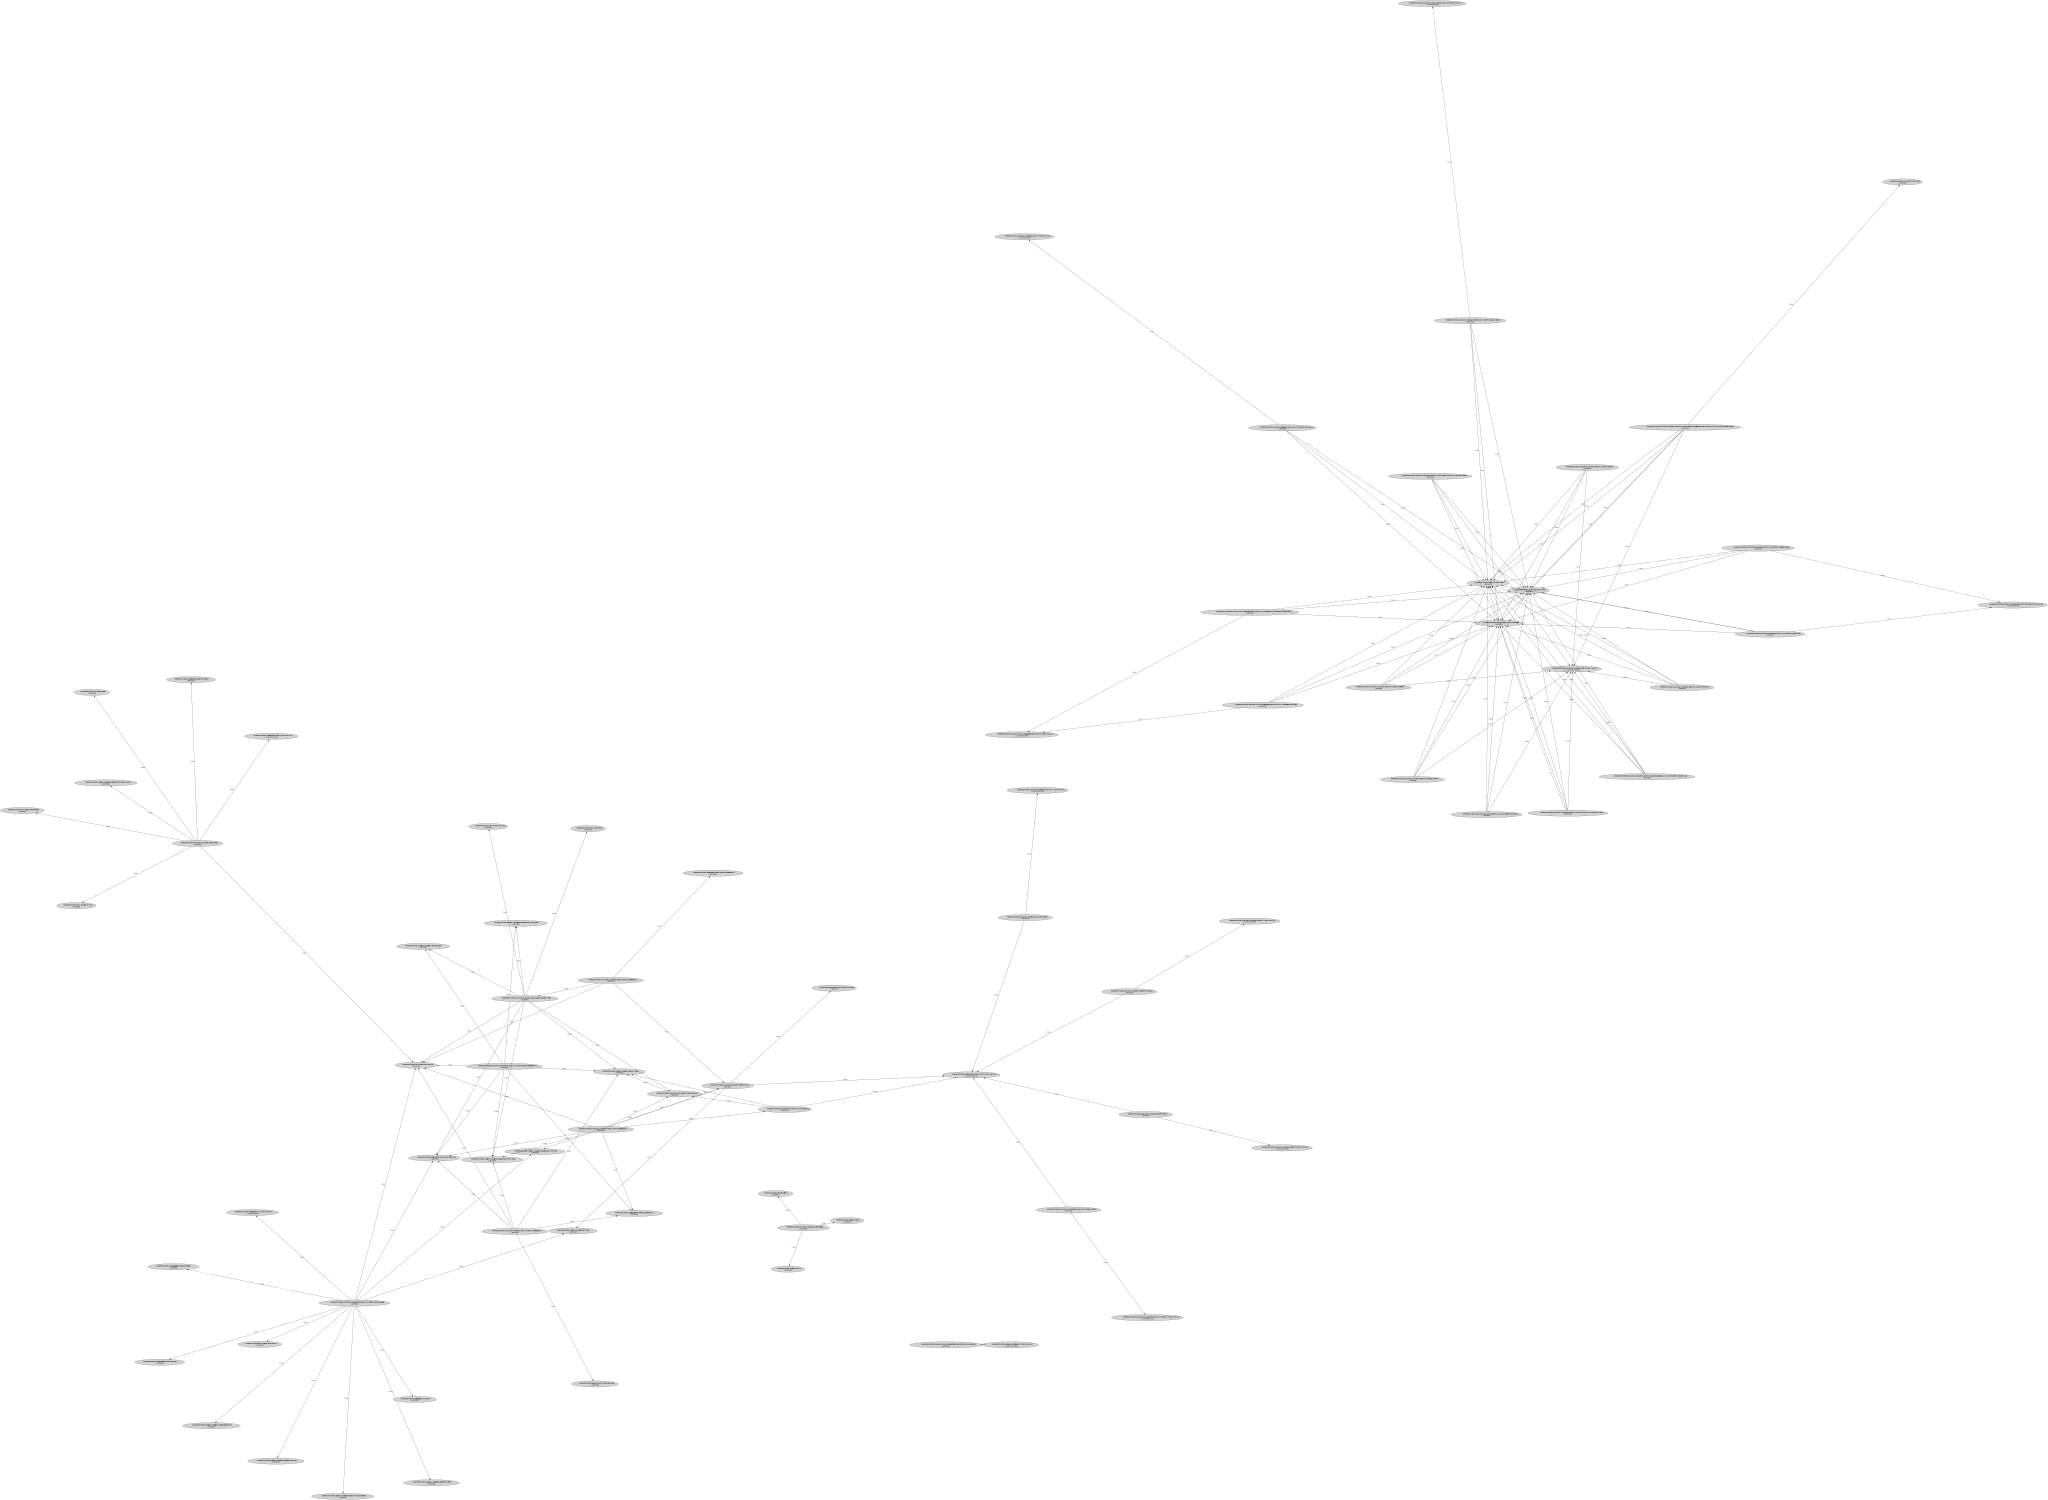

In [7]:
graphviz.set_jupyter_format("svg")
dot = graphviz.Digraph(
    "callgraph", comment="Call graph", engine="sfdp"
)

def apply_filter(node, node_map, seen):
    if node in seen or node not in node_map:
        return

    seen.add(node)
    to = node_map[node]
    for type in to:
        for next in node_map[node][type]:
            apply_filter(next, node_map, seen)


if filter_resources_related_to:
    node_map = {}
    for i, z in enumerate(
        zip(
            df["dependent"], df["toType"], df["dependency"], df["toType"]
        )
    ):
        dependent = str(z[0])
        dependentType = str(z[1])
        dependency = str(z[2])
        dependencyType = str(z[3])

        if not bool(node_map):
            node_map = {}

        if dependent not in node_map:
            node_map[dependent] = {}

        if dependentType not in node_map[dependent]:
            node_map[dependent][dependentType] = {}

        if dependency not in node_map[dependent][dependentType]:
            node_map[dependent][dependentType][dependency] = {}

        if dependencyType not in node_map[dependent][dependentType][dependency]:
            node_map[dependent][dependentType][dependency][dependencyType] = {i}

    seen = set()
    apply_filter(filter_resources_related_to, node_map, seen)

    df = df[
        (df["dependent"].isin(seen))
        if exclude_incoming_relationships == "true"
        else (df["dependent"].isin(seen))
        | (df["dependency"].str.contains(filter_resources_related_to))
    ]
    dot.graph_attr["beautify"] = "true"

def add_annotation(value, docType):
    return f"<<b>{html.escape(value)}</b><br/><i>({html.escape(docType)})</i>>"


def map_relationship(row):
    dot.node(
        make_node(row["dependent"], row["fromType"]),
        shape="Mdiamond"
        if filter_resources_related_to == row["dependent"]
        else node_shape,
        label=add_annotation(row["dependent"], row["fromType"]),
        style="filled",
    )
    dot.node(
        make_node(row["dependency"], row["toType"]),
        shape="Mdiamond"
        if filter_resources_related_to == row["dependency"]
        else node_shape,
        label=add_annotation(row["dependency"], row["toType"]),
        style="filled",
    )
    dot.edge(
        make_node(row["dependent"], row["fromType"]),
        make_node(row["dependency"], row["toType"]),
        label=make_label(
            row["action"], row["actionMetadata"] if "actionMetadata" in df else None
        ),
    )

def make_node(resource, type):
    if isinstance(resource, str) and isinstance(type, str):
        return resource + " " + type
    else:
        return resource

def make_label(action, action_metadata):
    if isinstance(action_metadata, str):
        return action + " " + f"({action_metadata})"
    else:
        return action


df.apply(map_relationship, axis=1)

dot.graph_attr = {
    "overlap": "prism",
    "normalize": "true",
    "overlap_scaling": "30",
    "size": "1250,auto",
    "nodesep": "1",
}

dot